# Finding the best way to interpolate

In [1]:
import d3dshot
import torch
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
d = d3dshot.create(capture_output="pytorch_float_gpu")

In [3]:
#high-speed screen capture
d.capture(region=(0, 0, 1920, 1080))

True

In [4]:
# stop it
d.stop()

True

In [4]:
image = d.get_latest_frame()

In [5]:
def downsample(tensor, scale_factor=0.03, mode='area', align_corners=None):
    """source tensor should be in 3D (H, W, C) tensor"""
    # interpolate accept size of (B, C, H, W) while B is the batch size, only 1
    tensor = tensor.permute(2, 0, 1).unsqueeze(0)
    downsampled = F.interpolate(tensor, scale_factor=scale_factor, mode=mode, align_corners=align_corners)
    # back to (H, W, C), for imshow right now
    downsampled = downsampled.squeeze(0).permute(1, 2, 0)
    return downsampled

In [6]:
def downupsample(tensor, scale_factor=0.03, mode='area', mode2='nearest', align_corners=None, align_corners2=None):
    """source tensor should be in 3D (H, W, C) tensor"""
    # interpolate accept size of (B, C, H, W) while B is the batch size, only 1
    tensor = tensor.permute(2, 0, 1).unsqueeze(0)
    downsampled = F.interpolate(tensor, scale_factor=scale_factor/2, mode=mode, align_corners=align_corners)
    upsampled = F.interpolate(downsampled, scale_factor=2, mode=mode2, align_corners=align_corners2)
    # back to (H, W, C), for imshow right now
    upsampled = upsampled.squeeze(0).permute(1, 2, 0)
    return upsampled

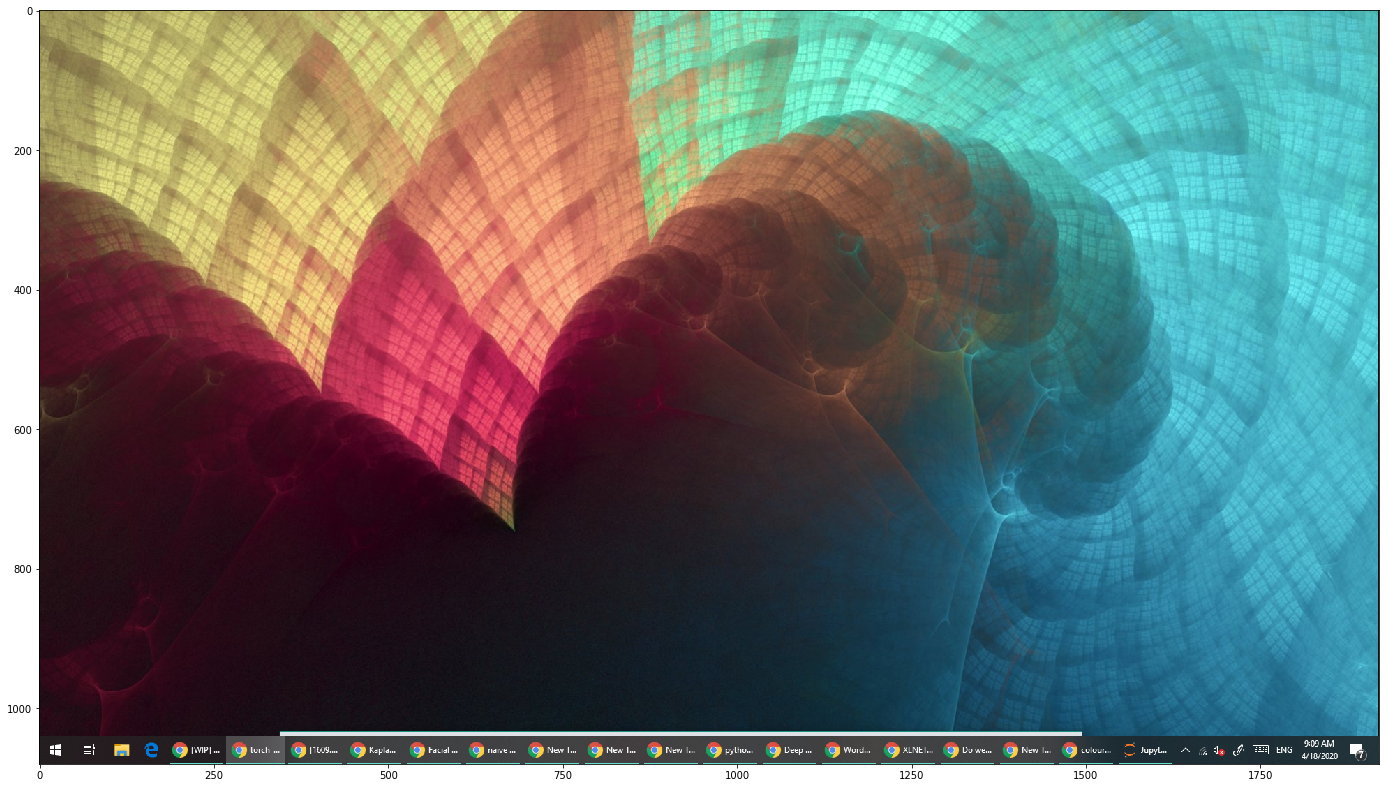

In [7]:
plt.figure(figsize=(24,16))
plt.imshow(image.cpu())
plt.show()

In [8]:
start_time = time.time()
downsample(image)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0009987354278564453 seconds ---


In [9]:
downsample(image).shape

torch.Size([32, 57, 3])

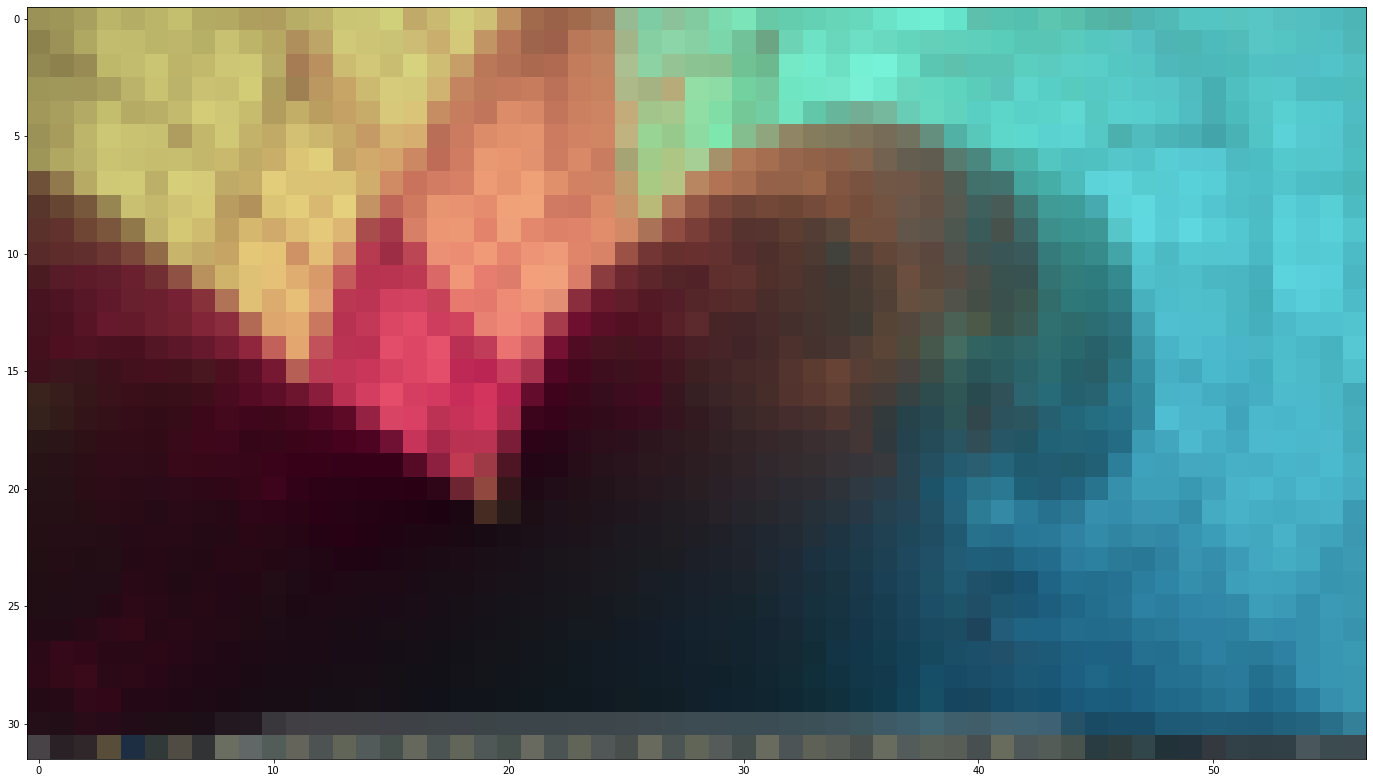

In [10]:
# area
image_r = downsample(image)
plt.figure(figsize=(24,16))
plt.imshow(image_r.cpu())
plt.show()

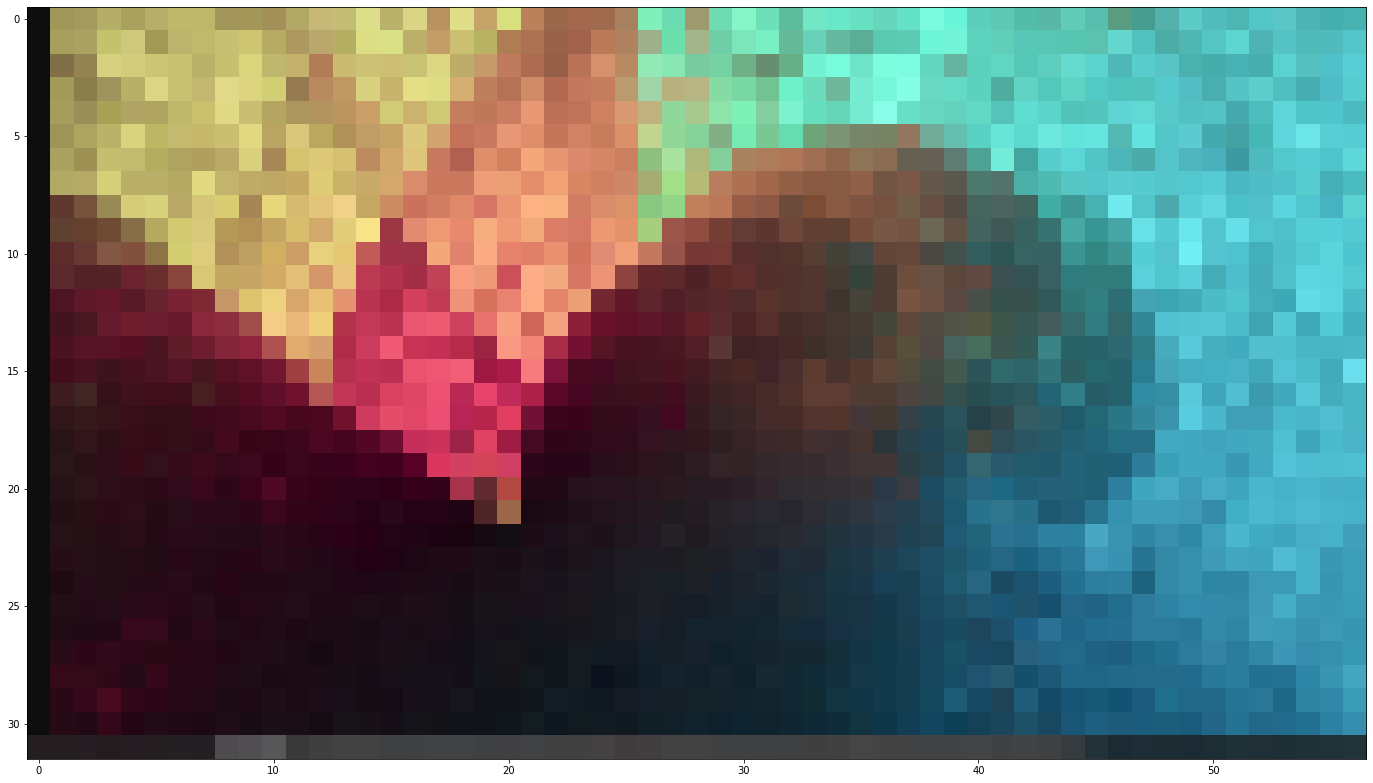

In [11]:
image_r1 = downsample(image, mode='nearest')
plt.figure(figsize=(24,16))
plt.imshow(image_r1.cpu())
plt.show()

C:\Users\King\Anaconda3\lib\site-packages\torch\nn\functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


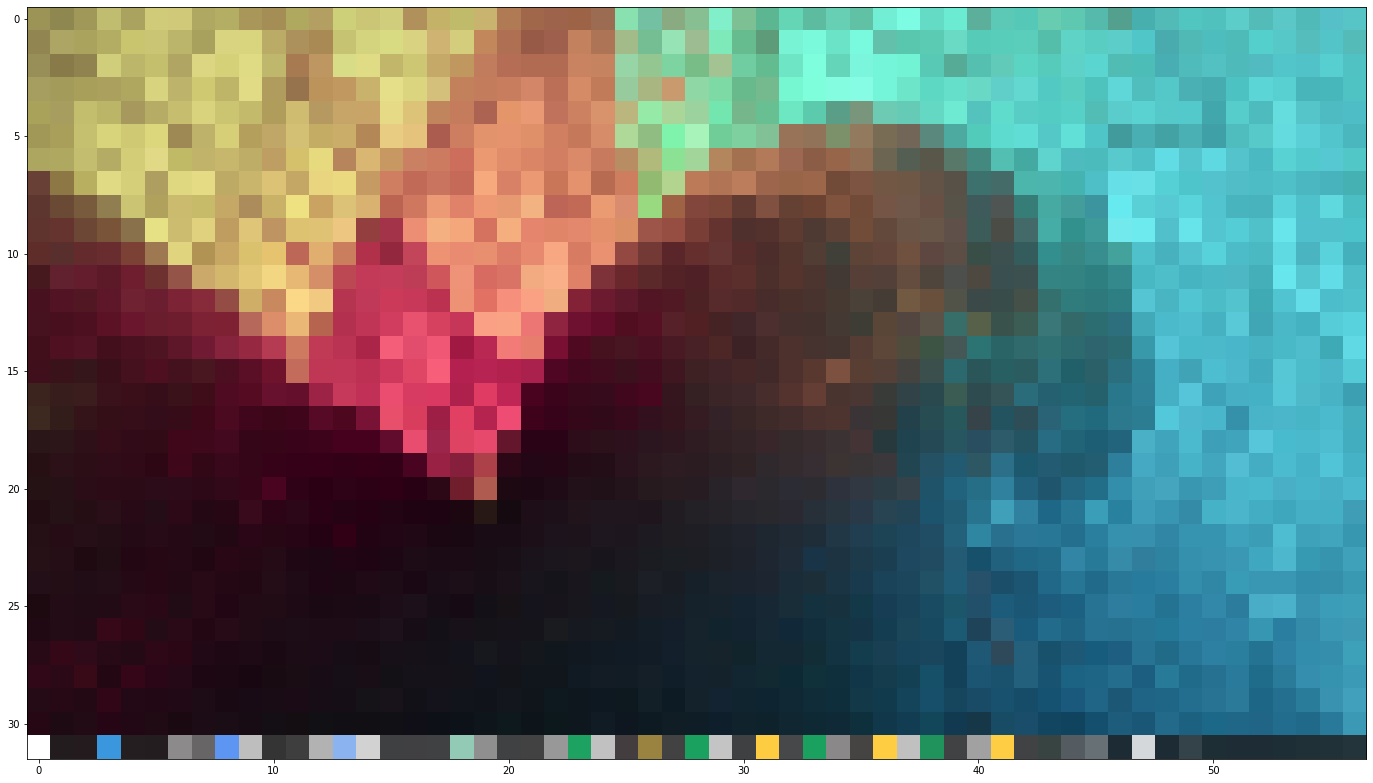

In [13]:
image_r2 = downsample(image, mode='bilinear')
plt.figure(figsize=(24,16))
plt.imshow(image_r2.cpu())
plt.show()

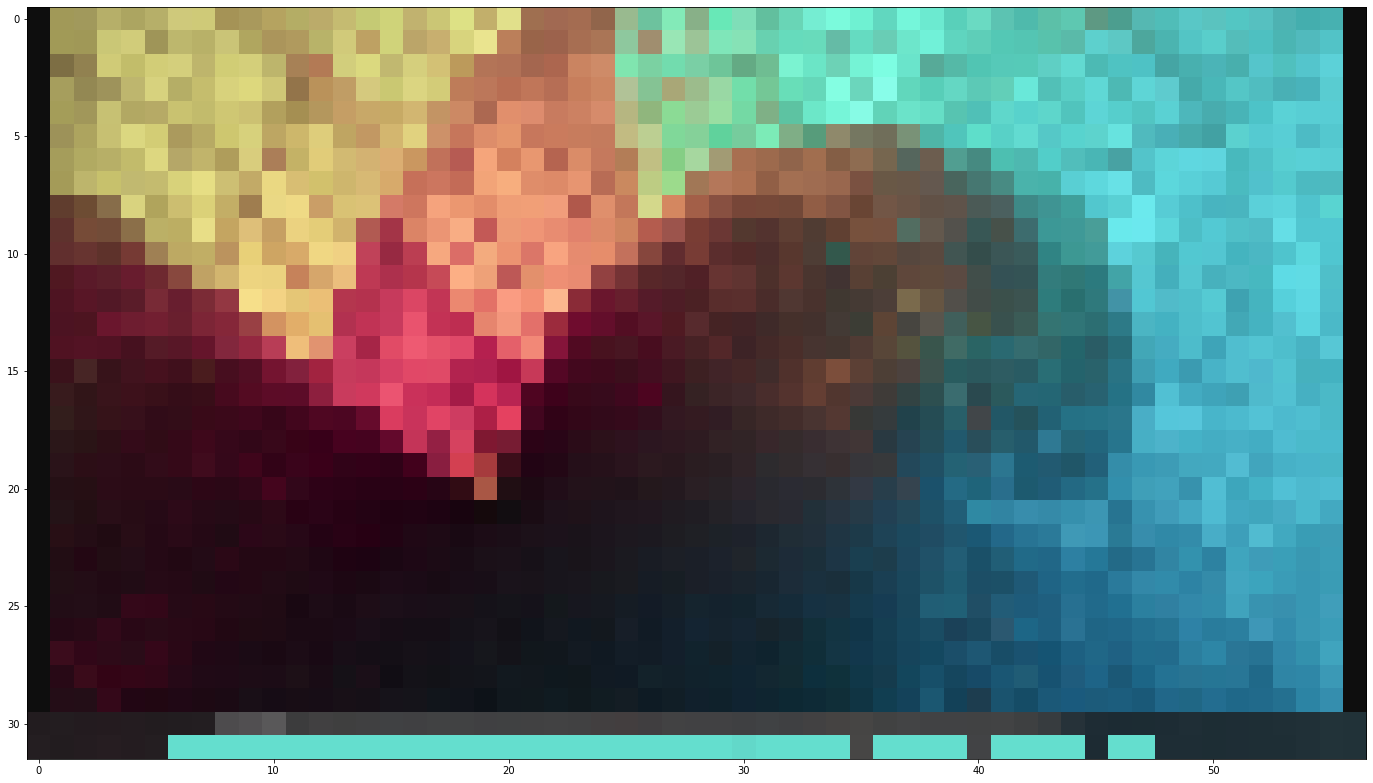

In [14]:
image_r2 = downsample(image, mode='bilinear', align_corners=True)
plt.figure(figsize=(24,16))
plt.imshow(image_r2.cpu())
plt.show()

# Downsample /2 and upsample *2

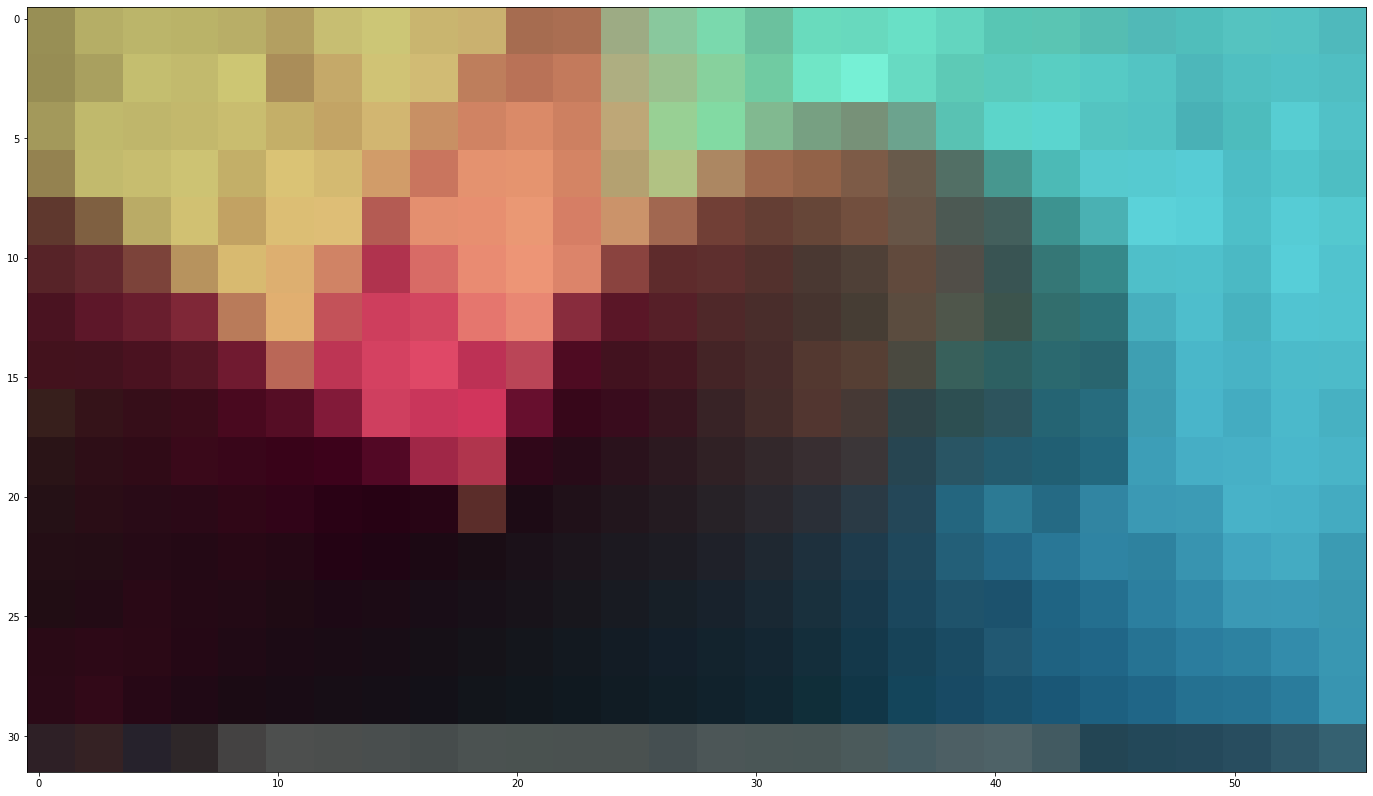

In [15]:
# default is area
image_ru = downupsample(image)
plt.figure(figsize=(24,16))
plt.imshow(image_ru.cpu())
plt.show()

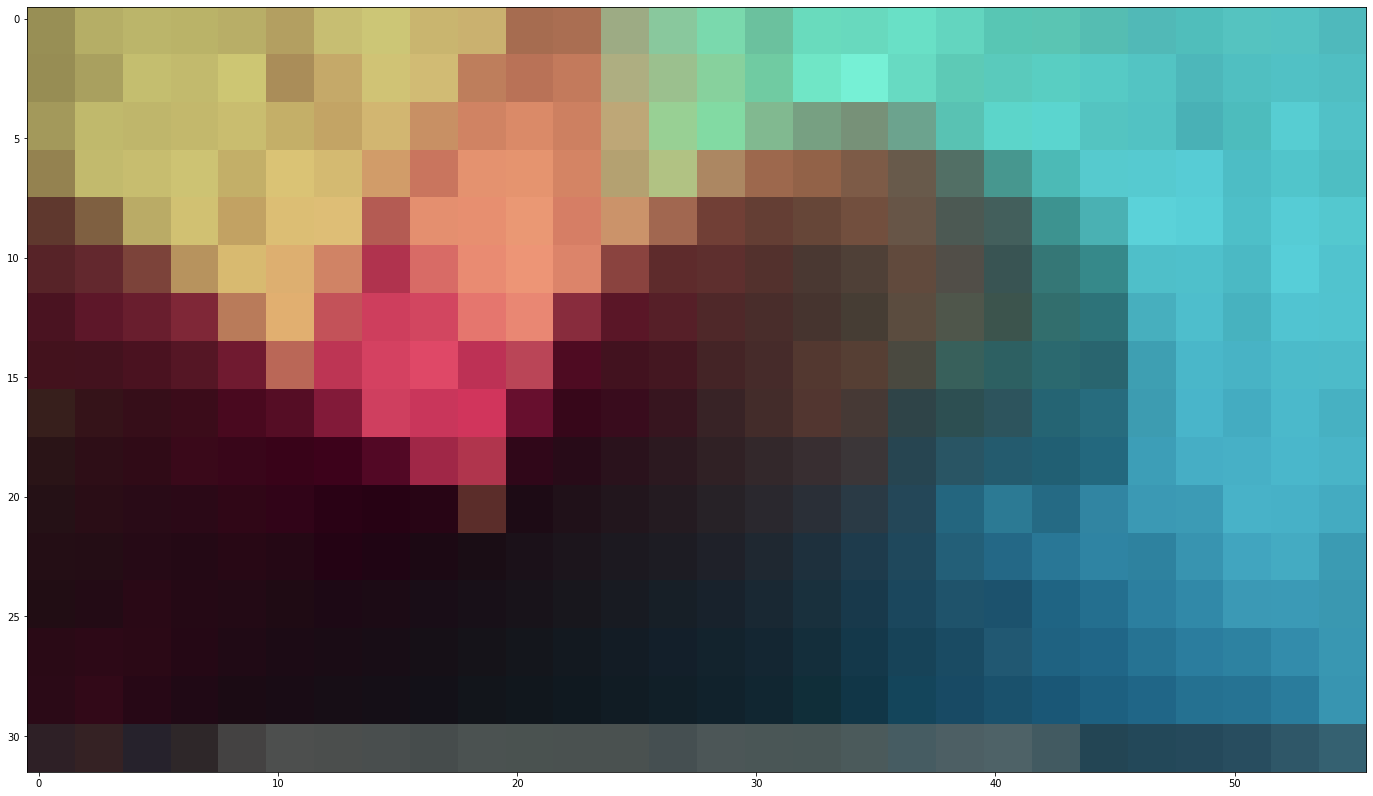

In [16]:
image_ru1 = downupsample(image, mode2='nearest')
plt.figure(figsize=(24,16))
plt.imshow(image_ru1.cpu())
plt.show()

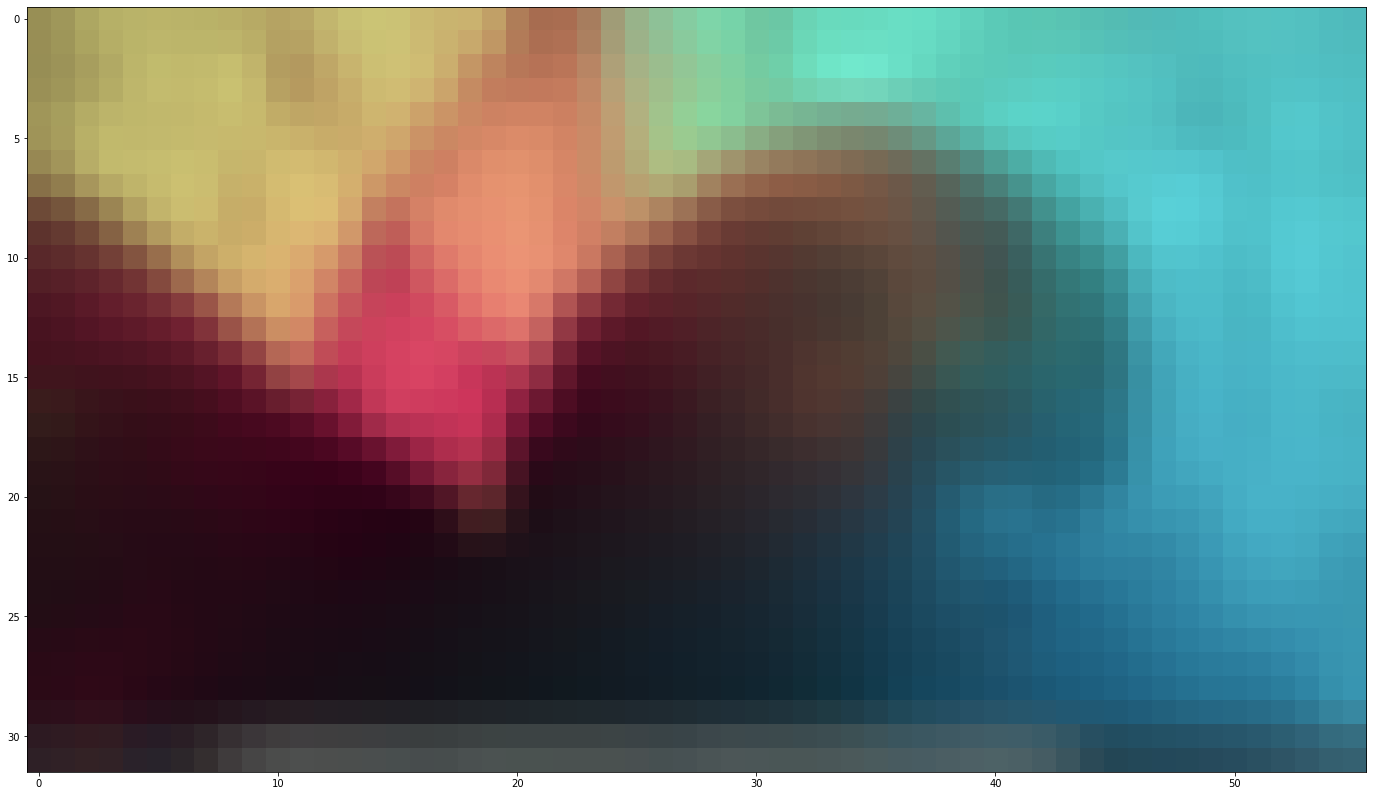

In [17]:
image_ru2 = downupsample(image, mode2='bilinear')
plt.figure(figsize=(24,16))
plt.imshow(image_ru2.cpu())
plt.show()

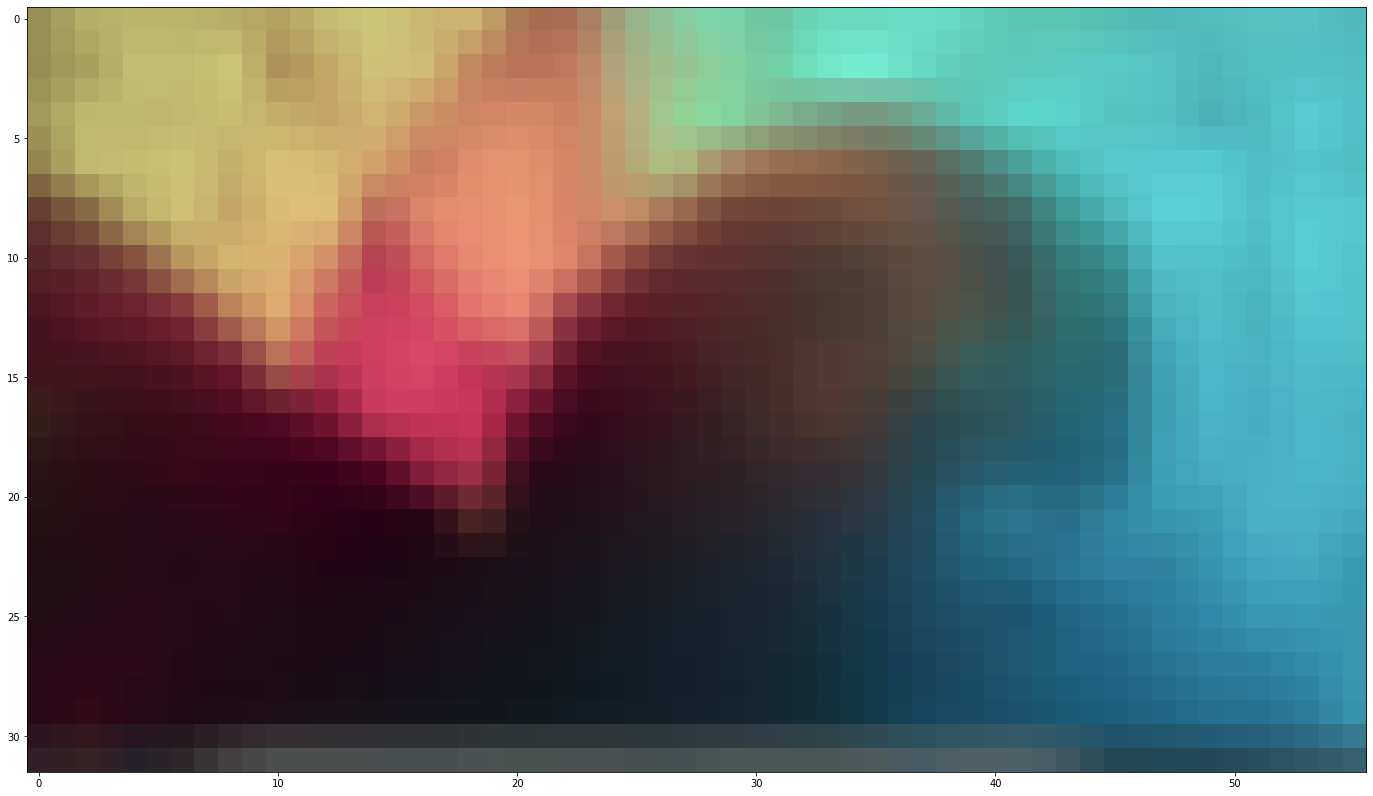

In [18]:
image_ru3 = downupsample(image, mode2='bilinear', align_corners2=True)
plt.figure(figsize=(24,16))
plt.imshow(image_ru3.cpu())
plt.show()

## bilinear without aligning the corners seems to best

# Let's invert the image for the left and bottom bar

In [19]:
# bilinear down up sample
image_ru2.shape

torch.Size([32, 56, 3])

In [20]:
image_ru2_F = torch.flip(image_ru2, [0, 1])
image_ru2_F.shape

torch.Size([32, 56, 3])

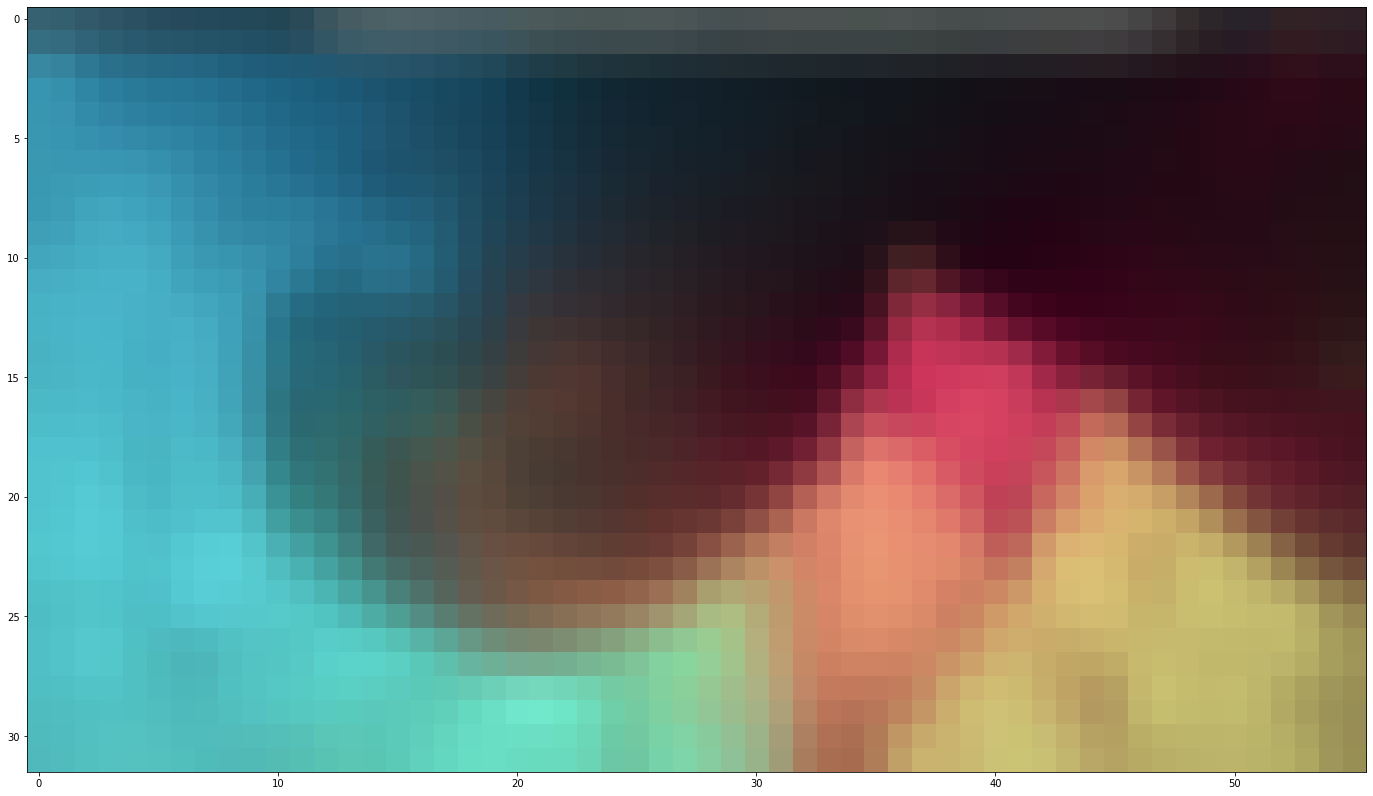

In [21]:
# Just to confirm
plt.figure(figsize=(24,16))
plt.imshow(image_ru2_F.cpu())
plt.show()

# Select and resize again

In [22]:
def resize_top_bottom(tensor, size):
    """source tensor should be in 2D (W, C) tensor"""
    # interpolate accept size of (B, C, H, W) while B is the batch size, only 1
    tensor = tensor.unsqueeze(0).permute(2, 0, 1).unsqueeze(0)
    resized = F.interpolate(tensor, size=size, mode='bilinear')
    # back to (H, W, C), for imshow right now
    resized = resized.squeeze(0).permute(1, 2, 0).squeeze(0)
    return resized

In [24]:
top = image_ru2[0, :, :]
top.shape

torch.Size([56, 3])

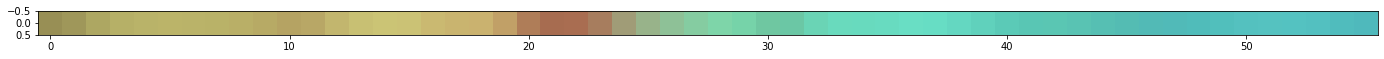

In [25]:
# unsqueeze(0) = Insert an extra dimension at position 0, as the height -> for plotting image
plt.figure(figsize=(24,16))
plt.imshow(top.unsqueeze(0).cpu())
plt.show()

Top needs 55

In [26]:
top_r = resize_top_bottom(top, size=(1, 55))
top_r.shape

torch.Size([55, 3])

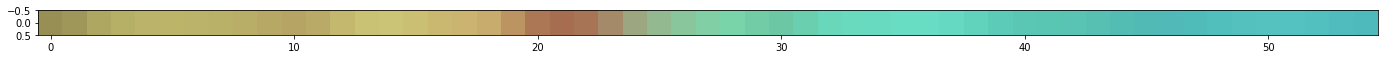

In [27]:
plt.figure(figsize=(24,16))
plt.imshow(top_r.unsqueeze(0).cpu())
plt.show()

In [28]:
bottom = image_ru2_F[0, :, :]

In [29]:
bottom.shape

torch.Size([56, 3])

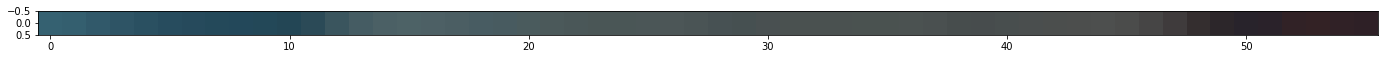

In [31]:
plt.figure(figsize=(24,16))
plt.imshow(bottom.unsqueeze(0).cpu())
plt.show()

Bottom needs 59

In [32]:
bottom_r = resize_top_bottom(bottom, size=(1, 59))
bottom_r.shape

torch.Size([59, 3])

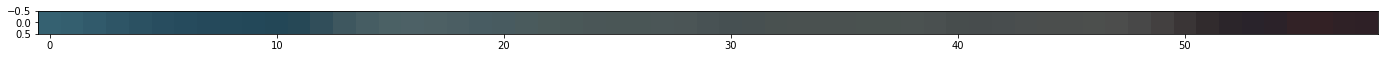

In [33]:
plt.figure(figsize=(24,16))
plt.imshow(bottom_r.unsqueeze(0).cpu())
plt.show()

In [61]:
right = image_ru2[1:-1, -1, :] #excluding first and last pixels (corners)
right.shape

torch.Size([30, 3])

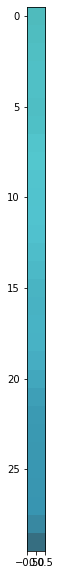

In [62]:
# unsqueeze(1) = Insert an extra dimension at position 1, as the width -> for plotting image
plt.figure(figsize=(24,10))
plt.imshow(right.unsqueeze(1).cpu())
plt.show()

In [63]:
left = image_ru2_F[1:-1, -1, :] #excluding first and last pixels (corners)
left.shape

torch.Size([30, 3])

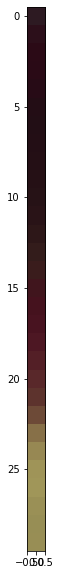

In [64]:
plt.figure(figsize=(24,10))
plt.imshow(left.unsqueeze(1).cpu())
plt.show()

In [65]:
data = torch.cat([bottom_r, left, top_r, right], 0)
data.shape

torch.Size([174, 3])

In [66]:
data[:3]

tensor([[0.2113, 0.3840, 0.4458],
        [0.2058, 0.3742, 0.4372],
        [0.1950, 0.3548, 0.4200]], device='cuda:0')

In [67]:
channel_data = torch.flatten(data)
channel_data.shape

torch.Size([522])

In [68]:
channel_data[:9]

tensor([0.2113, 0.3840, 0.4458, 0.2058, 0.3742, 0.4372, 0.1950, 0.3548, 0.4200],
       device='cuda:0')

In [69]:
channel_data_byte = torch.mul(channel_data, 255).to(torch.uint8)
channel_data_byte[:10]

tensor([ 53,  97, 113,  52,  95, 111,  49,  90, 107,  46], device='cuda:0',
       dtype=torch.uint8)